In [1]:
# Import basic libraries
import numpy as np 
import pandas as pd
import joblib # for saving models

In [2]:
# For Google Colab only
# from google.colab import files

In [3]:
# Load local data
data = pd.read_csv('data/data.csv',index_col = 'ID')

In [4]:
# Load data from GitHub
# data_url = 'https://raw.githubusercontent.com/gerald-liu/credit-card-default-prediction/master/data/data.csv?token=AIUUIXPDCVIHEXYNIDVP23K6UEHRA'
# data = pd.read_csv(data_url, index_col = 'ID')


## Variables
There are 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)


## Data Cleaning
- No missing values, but there are a few anomalous things
- Variable name:
    1. PAY_0 is very confusing, should be changed to PAY_1 in consistensy with other variable names
    2. Change target variable name from 'default.pay.next.month' to 'def_pay'
- Understand categorical and numerical data respectively


In [5]:
# Change variable name
data = data.rename(columns={'default.payment.next.month': 'def_pay', 'PAY_0': 'PAY_1'})

In [6]:
# To have a general idea of the default probability
data['def_pay'].value_counts()[1] / data.shape[0]

0.2212

In [7]:
# Categorical variables
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [8]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [9]:
# Missing values are filled with random value according to probability of occurrence
mask_edu_good=data['EDUCATION'].isin(range(1,5))
data['EDUCATION'].mask(~mask_edu_good,data['EDUCATION'][mask_edu_good].sample(n=(~mask_edu_good).sum(),replace=True).tolist(),inplace=True)
data['EDUCATION'].value_counts()

2    14190
1    10702
3     4982
4      126
Name: EDUCATION, dtype: int64

In [10]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [11]:
mask_marriage_good=data['MARRIAGE'].isin(range(1,4))
data['MARRIAGE'].mask(~mask_marriage_good,data['MARRIAGE'][mask_marriage_good].sample(n=(~mask_marriage_good).sum(),replace=True).tolist(),inplace=True)
data['MARRIAGE'].value_counts()

2    15993
1    13684
3      323
Name: MARRIAGE, dtype: int64

In [12]:
# Create lists for relevant numerical features
repayments = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amounts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [13]:
# final check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [14]:
# export to csv
data.to_csv('data/data_clean.csv')

# K Nearest Neighbor

KNN performs better when all features are numerical and continuous, here, we map all categorical features to a numerical values.

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
# Import module to standardize the scale
from sklearn.preprocessing import StandardScaler
# Create instance of the standard scaler
scaler = StandardScaler()
scaler.fit(data.drop('def_pay', axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
scaled_features = scaler.transform(data.drop('def_pay',axis=1))
scaled_features

array([[-1.13672015,  0.81016074,  0.25613532, ..., -0.30806256,
        -0.31413612, -0.29338206],
       [-0.3659805 ,  0.81016074,  0.25613532, ..., -0.24422965,
        -0.31413612, -0.18087821],
       [-0.59720239,  0.81016074,  0.25613532, ..., -0.24422965,
        -0.24868274, -0.01212243],
       ...,
       [-1.05964618, -1.23432296,  0.25613532, ..., -0.03996431,
        -0.18322937, -0.11900109],
       [-0.67427636, -1.23432296,  1.66141322, ..., -0.18512036,
         3.15253642, -0.19190359],
       [-0.90549825, -1.23432296,  0.25613532, ..., -0.24422965,
        -0.24868274, -0.23713013]])

In [18]:
# Use the scaled features to creata a data frame
features=pd.DataFrame(scaled_features,columns=data.columns[:-1])

In [19]:
# Import module to split the data
from sklearn.model_selection import train_test_split
X=features
y=data['def_pay']

In [20]:
# Import module for KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [21]:
from sklearn.model_selection import cross_val_score,cross_val_predict
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

In [22]:
scores.mean()

0.7921666666666667

In [23]:
# get predicted class for y
y_pred_class = cross_val_predict(knn,X,y,cv=10)

In [24]:
# Import classification report and confusion matrix to evaluate predictions
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred_class))
print("Classification Report:","\n", classification_report(y, y_pred_class))
cmat = confusion_matrix(y, y_pred_class)
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion Matrix: 
 [[21456  1908]
 [ 4327  2309]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     23364
           1       0.55      0.35      0.43      6636

    accuracy                           0.79     30000
   macro avg       0.69      0.63      0.65     30000
weighted avg       0.77      0.79      0.77     30000

Accuracy Rate: 0.7921666666666667
Misclassification Rate: 0.20783333333333334


### Evaluate alternative K-values for better predictions

In [26]:
error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    y_pred_class = cross_val_predict(knn,X,y,cv=10)
    error_rate.append(np.mean(y_pred_class != y))

Text(0, 0.5, 'Error Rate')

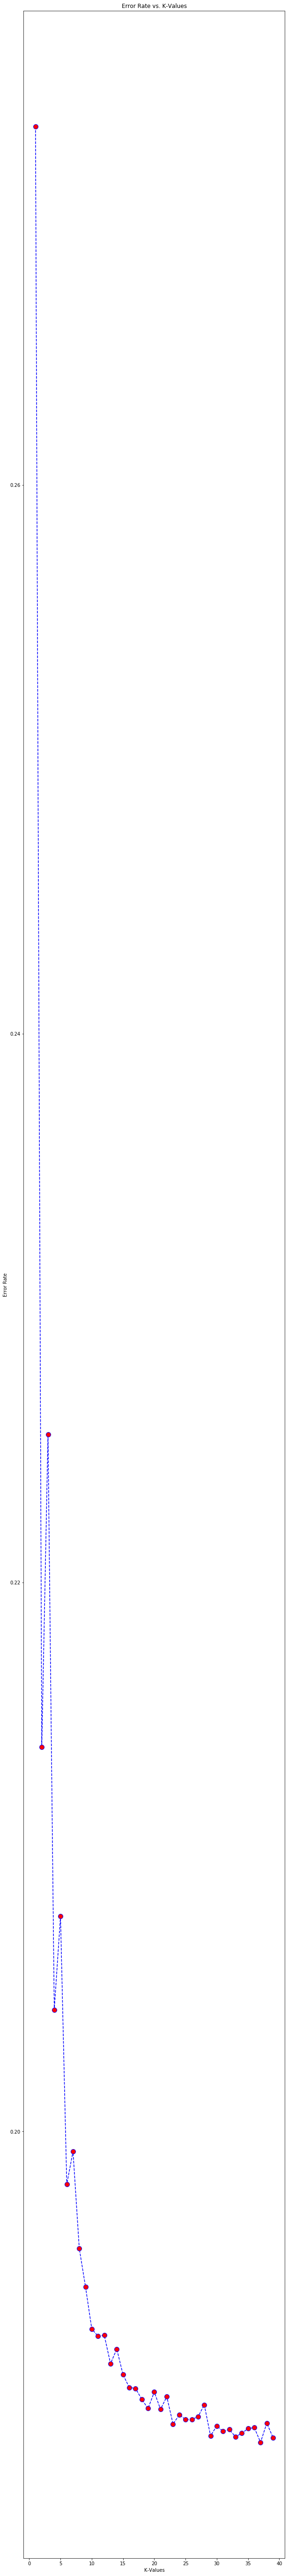

In [29]:
# Configure and plot error rate over k values
plt.figure(figsize=(10,100))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

The k-value of 23 seems to give a decent error rate without too much noise, as we see with k-values of 28 and larger.

### Fine tune the model

In [31]:
# Retrain model using optimal k-value
knn = KNeighborsClassifier(n_neighbors=23)
y_pred_class = cross_val_predict(knn,X,y,cv=10)

### Model Evaluation

In [32]:
cmat = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred_class))
print("Classification Report:","\n", classification_report(y, y_pred_class))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion Matrix: 
 [[22188  1176]
 [ 4504  2132]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.95      0.89     23364
           1       0.64      0.32      0.43      6636

    accuracy                           0.81     30000
   macro avg       0.74      0.64      0.66     30000
weighted avg       0.79      0.81      0.79     30000

Accuracy Rate: 0.8106666666666666
Misclassification Rate: 0.18933333333333333


In [35]:
from sklearn.model_selection import cross_val_score,cross_val_predict
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
scores.mean()

0.8106666666666665